### Import Libraries

In [46]:
#Generic import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
print(f'Pytorch version {torch.__version__}')

Pytorch version 2.0.1


In [47]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

### Select mass distribution profile

In [48]:
potential_type = 'plummer' #used to select potential {'plummer','?'}
unit_type = 'dimensionless' #used to select units {'galactic','dimensionless'}
orbited = False

G, M, b = 1, 1, .1
#G = constant.G.to(u.kpc*u.km**2/u.solMass/u.s**2)/(u.kpc*u.km**2/u.solMass/u.s**2) #Gravitonal Constant in desired units
#M = 1e4 #Total Mass of the System
#b = 1.5 #Scale Radius
m = 1 #Mass of a typical particle

np.save('G',float(G))
np.save('M', M)
np.save('b', b)

#Lambda functions for various potentials {KE ,PE, qpdf, vdlytic, vesc}
if potential_type == 'plummer':
    PE = lambda G, M, b, r : -(G*M) / (b**2 + r**2)**(1/2) #Potential Energy
    KE =  lambda m, v : (m/2)*(v**2) #Kinetic Energy
    qpdf = lambda q: ((7*np.pi)/512)*np.square(q)*np.power(np.subtract(1,np.square(q)),7/2) #Normalized velocity probability distribution function
    vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2))) #Analytic velocity dispersion
    vesc = lambda G, M, b, r: np.sqrt(2*G*M/np.sqrt(b**2+np.square(r))) #Escape velocity
    df_norm = lambda G, M, b: (24 * (b**2) * np.sqrt(2.) ) / (7. * (G**5) * (M**4) * (np.pi**3)) #Normalization for distibution function

if potential_type == '?':
    print('Update these definitions')

importlib.reload(toy_systems)

Pytorch version 2.0.1


<module 'toy_systems' from '/Users/andyhicks/DYNAMITE/toy_systems.py'>

### Initialize necessary functions

In [49]:
#Plots a heatmap from torch tensor
def plot_samples(eta):
        fig,ax_arr = plt.subplots(
            3,3,
            figsize=(13,12),
            subplot_kw=dict(aspect='equal')
        )
        fig.subplots_adjust(wspace=0.30, hspace=0.25)

        xlim = (-3., 3.)
        vlim = (-.3, .3)

        for k,(i,j) in enumerate([(0,1), (0,2), (1,2)]):
            ax_arr[0,k].hist2d(eta[:,i], eta[:,j], bins=31, range=[xlim,xlim])
            ax_arr[1,k].hist2d(eta[:,i+3], eta[:,j+3], bins=31, range=[vlim,vlim])

            ax_arr[0,k].set_xlabel(rf'$x_{i}$')
            ax_arr[0,k].set_ylabel(rf'$x_{j}$', labelpad=-5)
            ax_arr[1,k].set_xlabel(rf'$v_{i}$')
            ax_arr[1,k].set_ylabel(rf'$v_{j}$', labelpad=-5)
        r = np.sqrt(np.sum(eta[:,:3]**2, axis=1))
        v = np.sqrt(np.sum(eta[:,3:]**2, axis=1))
        ax_arr[2,0].hist2d(r, v, bins=31, range=[(0.,5.),(0.,1.5)])
        ax_arr[2,0].set_xlabel(r'$r$')
        ax_arr[2,0].set_ylabel(r'$v$', labelpad=0)
        
        bins = 11
        v0 = eta.shape[0] / bins**2
        dv = 0.5*v0

        theta, phi = vec2ang(eta[:,:3])
        ax_arr[2,1].hist2d(
            phi, np.sin(theta),
            bins=bins,
            vmin=v0-dv, vmax=v0+dv,
            cmap='bwr_r'
        )
        ax_arr[2,1].set_xlabel(r'$\varphi_x$')
        ax_arr[2,1].set_ylabel(r'$\sin \theta_x$', labelpad=-5)

        theta, phi = vec2ang(eta[:,3:])
        ax_arr[2,2].hist2d(
            phi, np.sin(theta),
            bins=bins,
            vmin=v0-dv, vmax=v0+dv,
            cmap='bwr_r'
        )
        ax_arr[2,2].set_xlabel(r'$\varphi_v$')
        ax_arr[2,2].set_ylabel(r'$\sin \theta_v$', labelpad=-5)

        for a in ax_arr[2]:
            a.set_aspect('auto')

        return fig

#Calculates theta and phi from cartesian coordinates.
def vec2ang(x):
    phi = np.arctan2(x[:,1], x[:,0])
    theta = np.arctan2(x[:,2], np.sqrt(x[:,0]**2+x[:,1]**2))
    return theta, phi

#Generates mock data for an idealized plummer sphere.
plummer_sphere = toy_systems.PlummerSphere()
def sample_df(n_samples, max_dist=None):
    """
    Returns phase-space locations sampled from the Plummer sphere
    distribution function. The shape of the output is
    (n_samples, 6).
    """
    #Generates coordinates in phase-space from that lie in a spherical spatial region.
    x,v = plummer_sphere.sample_df(n_samples)
    if max_dist is not None:
        r2 = np.sum(x**2, axis=1)
        idx = (r2 < max_dist**2)
        x = x[idx]
        v = v[idx]
    
    return torch.cat([torch.Tensor(x.astype('f4')), torch.Tensor(v.astype('f4'))], axis=1) , x , v

#Dispersion function calculated using in binned_statistics.
def dispersion(v):
    return np.sqrt(sum(np.square(np.subtract(v,sum(v)/len(v))))/len(v))
    n = 1
    vdn = vd
    for i in range(0,cycles):
        diff = sum(np.subtract(vr2_ideal,vdn))
        if diff > 0: n = n + .001
        elif diff < 0: n = n - .0003
        vdn = np.multiply(vd,n)
    return vdn, n

#Converts a 6D phase space pd data frame into a spatial and momentum np array.
def pd2np_6D(pd_data):
    np_data = pd_data.to_numpy()
    qT = [np_data[:,0],np_data[:,1],np_data[:,2]]
    q = np.transpose(qT)
    pT = [np_data[:,3],np_data[:,4],np_data[:,5]]
    p = np.transpose(pT)
    data = torch.cat([torch.Tensor(q.astype('f4')), torch.Tensor(p.astype('f4'))], axis=1)
    return data, q, p

#Converts cartesian coordinates into spherical cooridnates.
def sfurical(x,y,z,v_x,v_y,v_z):
    
    R = np.sqrt(x**2+y**2) #for convenience
    r = np.sqrt(x**2+y**2+z**2)

    theta = np.arccos(z/r)
    phi   = np.arctan2(y,x)

    # (vx,vy,vz) -> (vr,v_{\theta},v_{\phi})
    vr     =  ( x * v_x  + y * v_y + z * v_z )/ r    
    vphi   = (y * v_x - x * v_y)/ R
    vtheta = (z * x * v_x/R  + z * y * v_y/R - R * v_z)/r
    return r, vr, vtheta, vphi

#Calculates the dispersion relation.
def vd(r,vr,vtheta,vphi,t):
    N , bin_edges= histogram(r[t],bins='blocks')
    r_center = (bin_edges[:-1] + bin_edges[1:])/2
    vmean ,_,__  = stats.binned_statistic(r[t],vr[t], statistic = 'mean', bins = bin_edges)
    error = np.multiply(1/np.sqrt(N),vmean)
    vdr     ,_,__ = stats.binned_statistic(r[t],vr[t], statistic = dispersion, bins = bin_edges)
    vdtheta     ,_,__ = stats.binned_statistic(r[t],vtheta[t], statistic = dispersion, bins = bin_edges)
    vdphi     ,_,__ = stats.binned_statistic(r[t],vphi[t], statistic = dispersion, bins = bin_edges)
    return r_center, vdr, vdtheta, vdphi

#Generates the true distribution function.
def df_ideal(q, p):
    r2 = torch.sum(q**2, axis=1)
    v2 = torch.sum(p**2, axis=1)
    G2 = float(G)

    if potential_type == 'plummer':
        E = PE(G2,M,b,r2)+KE(m,v2)
        f = torch.clamp(-E, 0, np.inf)**(7/2)

    A = df_norm(G2,M,b)

    return A * f

### Import 6D phase-space data to be used

In [50]:
#Generates mock data from Plummer Sphere Toy_system
runcell = True
if runcell == True:
    f = np.load('f.npy') + 1
    f = np.save('f',f)
    n_samples = 10000
    data, q, p = sample_df(n_samples)
    print('Generating mock plummer data with ' + str(n_samples) + ' samples using G = ' + str(G) + ', M = ' + str(M) + ', and b = ' + str(b))
    f_name = 'G' + str(G) + '_M' + str(M) + '_b' + str(b) + '_n' + str(n_samples) + '_f' + str(np.load('f.npy')) + '.csv'
    pd.DataFrame(data).to_csv(f'/Users/andyhicks/DYNAMITE/Data Set/'+ f_name)
    print('saving as ' + f_name)


In [51]:
#Loads mock data from an external source
runcell = False
if runcell == True:
    pd_data = pd.read_csv(f'/Users/andyhicks/DYNAMITE/Data Set/G1_M1_b0.1_n10000_f6.csv')
    data, q, p = pd2np_6D(pd_data)
    n_samples = len(p)


### Phase-space Heat Map

In [52]:
#Plots Phase-Space Heat map
runcell = False
if runcell == True:
    fig = plot_samples(data.numpy())
    fig.savefig('df_samples.png', dpi=100)

### Residuals

/var/folders/pj/3qb2clws5tv2b9nh7f_0bqww0000gn/T/ipykernel_13870/4283648996.py:38: RuntimeWarning: divide by zero encountered in log
  img = np.log(n)
/var/folders/pj/3qb2clws5tv2b9nh7f_0bqww0000gn/T/ipykernel_13870/4283648996.py:76: RuntimeWarning: invalid value encountered in divide
  img1 = (n_samp - n)/n
/var/folders/pj/3qb2clws5tv2b9nh7f_0bqww0000gn/T/ipykernel_13870/4283648996.py:88: RuntimeWarning: divide by zero encountered in log
  img2 = np.log(n_samp) - np.log(n)
/var/folders/pj/3qb2clws5tv2b9nh7f_0bqww0000gn/T/ipykernel_13870/4283648996.py:88: RuntimeWarning: invalid value encountered in subtract
  img2 = np.log(n_samp) - np.log(n)


\int f(x,v) d^3x d^3v = 0.00113


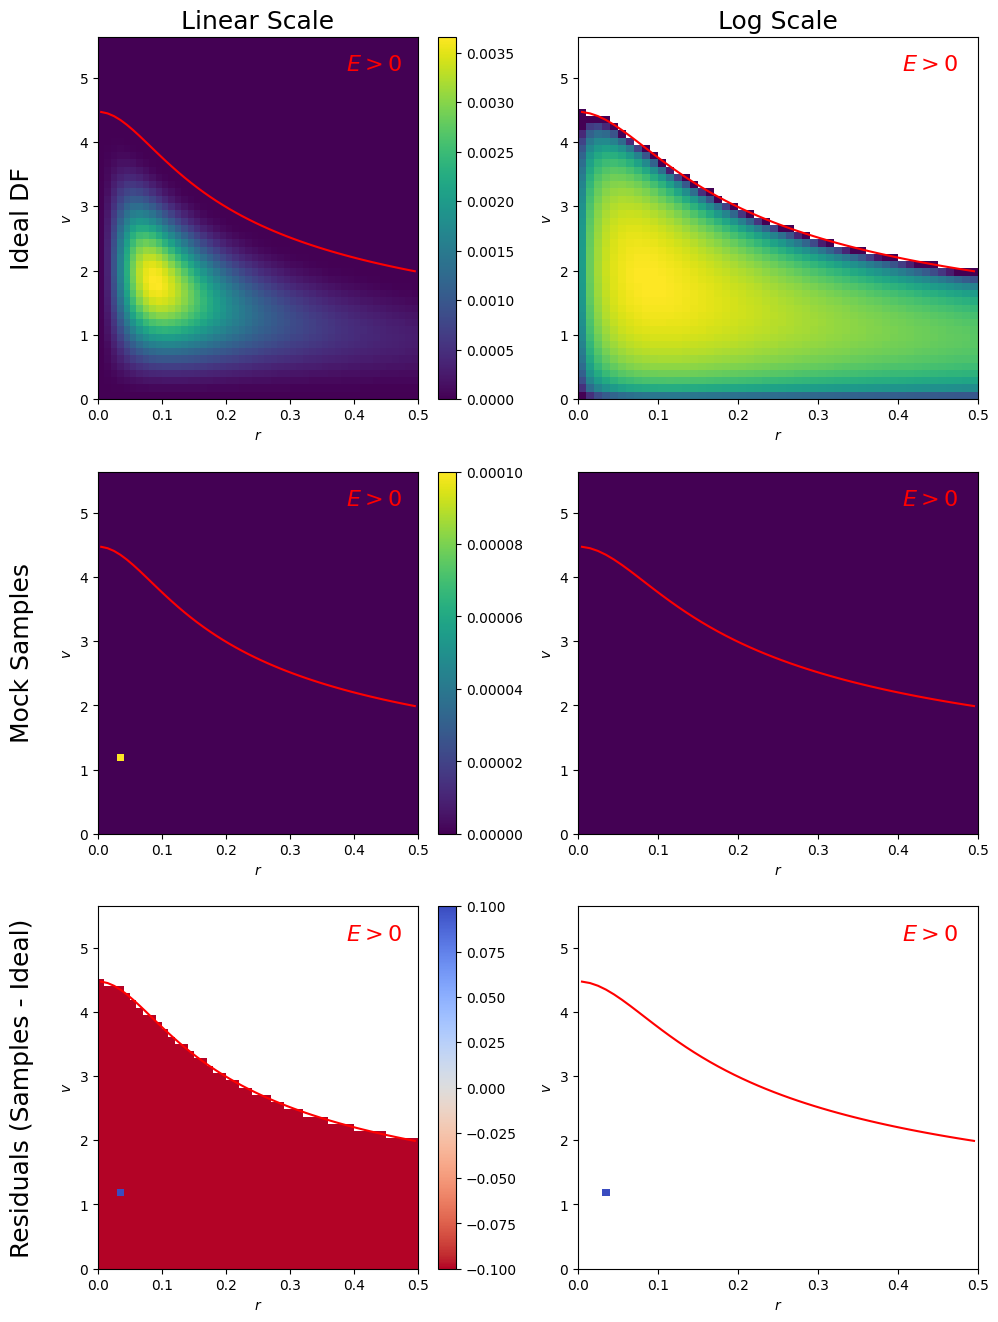

In [53]:
#Plots a histogram of the sample data as well as an ideal distribution for a Plummer Sphere Potential
runcell = True
if runcell == True:

    v_max = 1.5*vesc(G,M,b,b)
    r_max = 5*b
    r_lim = (0., r_max)
    v_lim = (0., v_max)
    bins = (50, 50)

    r = np.linspace(r_lim[0], r_lim[1], bins[0]+1)
    v = np.linspace(v_lim[0], v_lim[1], bins[1]+1)

    r = 0.5 * (r[:-1] + r[1:])
    v = 0.5 * (v[:-1] + v[1:])

    rr,vv = np.meshgrid(r, v)

    E = -(PE(G,M,b,rr)+KE(m,vv))
    df = np.clip(E, 0., np.inf)**(7/2)
    A = df_norm(G,M,b)

    n = A * (4*np.pi)**2 * rr**2 * vv**2 * df
    n = n/sum(sum(n))

    fig,ax_arr = plt.subplots(3,2, figsize=(11,16))
    fig.subplots_adjust(left=0.1)

    # Ideal distribution
    a00 = ax_arr[0,0].imshow(
        n,
        extent=r_lim+v_lim,
        origin='lower',
        aspect='auto',
        interpolation='nearest'
    )

    img = np.log(n)
    vmax = np.max(img)
    a01 = ax_arr[0,1].imshow(
        img,
        extent=r_lim+v_lim,
        vmax=vmax,
        vmin=vmax-10.,
        origin='lower',
        aspect='auto',
        interpolation='nearest'
    )


    dr = r[1] - r[0]
    dv = v[1] - v[0]
    N = np.sum(n) * dr * dv
    print(f'\int f(x,v) d^3x d^3v = {N:.5f}')

    # 2D histogram of samples
    x_samp,v_samp = q, p
    n_samples = len(x_samp)
    r_samp = np.sqrt(np.sum(x_samp**2, axis=1))
    v_samp = np.sqrt(np.sum(v_samp**2, axis=1))

    weights = np.ones_like(r_samp)/len(r_samp)
    n_samp,_,_,h_bar = ax_arr[1,0].hist2d(r_samp, v_samp, bins=bins, range=[r_lim,v_lim], weights = weights)
    n_samp = n_samp.T
    n_samp = n_samp/sum(sum(n_samp))


    h = ax_arr[1,1].hist2d(
        r_samp, v_samp,
        bins=bins,
        range=[r_lim,v_lim],
        norm=mcolors.LogNorm()
    )

    # Residuals (samples - ideal)
    img1 = (n_samp - n)/n
    a20 = ax_arr[2,0].imshow(
        img1,
        extent=r_lim+v_lim,
        vmax=.1,
        vmin=-.1,
        origin='lower',
        aspect='auto',
        cmap='coolwarm_r',
        interpolation='nearest'
    )

    img2 = np.log(n_samp) - np.log(n)
    a21 = ax_arr[2,1].imshow(
        img2,
        extent=r_lim+v_lim,
        vmax=1.,
        vmin=-1.,
        origin='lower',
        aspect='auto',
        cmap='coolwarm_r',
        interpolation='nearest'
    )

    # Zero-energy line
    for a in ax_arr.flat:
        a.plot(r,np.sqrt(G*M*2.) * (b**2+r**2)**(-1/4), c='r')
        a.set_xlabel(r'$r$')
        a.set_ylabel(r'$v$')
        a.text(
            0.95, 0.95, r'$E > 0$',
            ha='right', va='top',
            fontsize=16, c='r',
            transform=a.transAxes
        )

    # Labels
    pos = ax_arr[0,0].get_position()
    y_txt = 0.5 * (pos.y0 + pos.y1)
    fig.text(
        0.02, y_txt,
        r'Ideal DF',
        rotation=90.,
        ha='left',
        va='center',
        fontsize=18,
    )

    pos = ax_arr[1,0].get_position()
    y_txt = 0.5 * (pos.y0 + pos.y1)
    fig.text(
        0.02, y_txt,
        r'Mock Samples',
        rotation=90.,
        ha='left',
        va='center',
        fontsize=18,
    )

    pos = ax_arr[2,0].get_position()
    y_txt = 0.5 * (pos.y0 + pos.y1)
    fig.text(
        0.02, y_txt,
        r'Residuals (Samples - Ideal)',
        rotation=90.,
        ha='left',
        va='center',
        fontsize=18,
    )

    #Colorbars
    plt.colorbar(a00)
    #plt.colorbar(a01)
    plt.colorbar(h_bar)
    #plt.colorbar(h[3])
    plt.colorbar(a20)
    #plt.colorbar(a21)

    ax_arr[0,0].set_title('Linear Scale', fontsize=18)
    ax_arr[0,1].set_title('Log Scale', fontsize=18)

    plt.show()

### Compare with PDF

In [54]:
runcell = False
if runcell == True:
    v = np.sqrt(sum(p.T**2))
    r = np.sqrt(sum(q.T**2))
    q_test = v/vesc(G,M,b,r)
    q_test = np.sort(q_test)
    weights = np.ones_like(q_test)/len(q_test)*.2
    max_prob = np.ones_like(q_test)*np.max(qpdf(q_test))
    plt.hist(q_test, histtype="step", bins = 100, weights = weights, label = 'mock')
    plt.plot(q_test,qpdf(q_test), color = 'r', label = 'pdf')
    plt.plot(q_test,max_prob)
    plt.xlabel('velocities (v/v_esc)')
    plt.ylabel('probability')
    plt.title('Sample Accuracy')
    plt.legend()
    plt.show()

### Train Flows with Flow_Torch

In [55]:
n_flows = 6
n_dim = 6
n_units = 4
n_epochs = 32
batch_size = 512
n_steps = n_samples * n_epochs // batch_size
print(f'n_steps = {n_steps}')

n_steps = 625


In [56]:
runcell = False
if runcell == True:
    for i in tqdm(range(n_flows)):
        print(f'Training flow {i+1} of {n_flows} ...')
        #Initializes and trains the Normalizing Flow model (I think?)
        flow = flow_torch.NormalizingFlow(n_dim, n_units)
        loss_history = flow_torch.train_flow(
            flow, data, 
            n_epochs=n_epochs,
            batch_size=batch_size,
            callback=flow_torch.get_training_callback(
                flow,
                plt_fn=None,
                every=1024, 
            )
        )

        torch.save(flow.state_dict(), f'/Users/andyhicks/Desktop/REVU/deep-potential-master/plummer_flow_{i:02d}.pth')
        
        x_sample = flow.dist.sample(sample_shape=[128*1024])
        y_sample, _ = flow.backward(x_sample)
        fig = plot_samples(y_sample.detach().numpy())
        fig.savefig(f'plummer_flow_{i:02d}.png', dpi=100)
        plt.close(fig)

### NF Gradients (Idealized Plummer Potential only atm)

In [57]:
#Calculate the NF Gradients
runcell = False
if runcell == True:

    x = Variable(torch.Tensor(q.astype('f4')), requires_grad=True)
    v = Variable(torch.Tensor(p.astype('f4')), requires_grad=True)

    #Calculates the derivatives and defines the idealized distribution function from these sample data points.
    f_ideal, df_dx, df_dv = potential_torch.calc_df_deta(df_ideal, x, v)

    eta = torch.cat([x,v], axis=1)

    #Initializes the arrays of proper size and populates them with zeroes.
    f_star_list, dflow_dx_list, dflow_dv_list = [], [], []
    f_star = np.zeros_like(f_ideal.detach().numpy())
    dflow_dx = np.zeros_like(df_dx.detach().numpy())
    dflow_dv = np.zeros_like(df_dv.detach().numpy())

    for i in range(n_flows):
        print(f'Loading flow {i+1} of {n_flows} ...')
        
        #Loads flow data and assigns it to the variable 'flow'
        fname = f'/Users/andyhicks/Desktop/REVU/deep-potential-master/plummer_flow_{i:02d}.pth'
        state_dict = torch.load(fname)
        flow = flow_torch.NormalizingFlow(n_dim, n_units)
        flow.load_state_dict(state_dict)

        #Indexes the flow data over the previously defined phase-space and raises it to an exponential (I think?)
        def get_f_star(x, v):
            eta = torch.cat([x,v], axis=1)
            _ , prior_logprob, log_det = flow(eta)
            c = prior_logprob + log_det
            return torch.exp(c)
        
        #Generates the data for f* and its derivatives.
        res = potential_torch.calc_df_deta(get_f_star, x, v)
        f_star_list.append(res[0].detach().numpy())
        dflow_dx_list.append(res[1].detach().numpy())
        dflow_dv_list.append(res[2].detach().numpy())

        f_star += res[0].detach().numpy() / n_flows
        dflow_dx += res[1].detach().numpy() / n_flows
        dflow_dv += res[2].detach().numpy() / n_flows

    print('Done.')

In [58]:
#Plots NF gradients vs idealized gradients
runcell = False
if runcell == True:
    fig,ax_arr = plt.subplots(2,3, figsize=(16,9))

    #Returns the mean value of the passed array (I think?)
    def sigma_clipped_mean(x, n_sigma=3.):
        #Computes the STD deviation for the x array
        sigma = np.std(x, axis=0)
        #Computes the median value for the x array
        mu = np.median(x, axis=0)
        idx = np.abs(x - mu[None,...]) < n_sigma*(sigma[None,...]+1.e-8)
        w = idx.astype(x.dtype)
        x_avg = np.sum(x*w, axis=0) / np.sum(w, axis=0)
        return x_avg

    #Returns the mean value of the derivates
    df_dx_est = sigma_clipped_mean(np.stack(dflow_dx_list, axis=0), n_sigma=5)
    df_dv_est = sigma_clipped_mean(np.stack(dflow_dv_list, axis=0), n_sigma=5)

    #Plots the computed values for the derivatives against true values
    for i,ax in enumerate(ax_arr.flat):
        ax.set_aspect('equal')
        if i < 3:
            ax.scatter(
                #
                df_dx[:,i].detach(),
                df_dx_est[:,i],
                alpha=0.1, s=2,
                edgecolors='none'
            )
        else:
            ax.scatter(
                df_dv[:,i-3].detach(),
                df_dv_est[:,i-3],
                alpha=0.1, s=2,
                edgecolors='none'
            )

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xlim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)

        ax.plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], c='k', alpha=0.25)

        ax.set_xlabel(r'true')
        ax.set_ylabel(r'normalizing flow')

        ax.set_title(rf'$\mathrm{{d}}f / \mathrm{{d}}\eta_{i}$')

    fig.subplots_adjust(
        hspace=0.25, wspace=0.3,
        top=0.91, bottom=0.06
    )
    fig.suptitle('Performance of normalizing flow gradients', fontsize=20)

    fig.savefig('flow_gradients_comparison.png', dpi=100)

In [59]:
#Plots histogram of deviation from ideal
runcell = False
if runcell == True:
    fig,ax_arr = plt.subplots(2,3, figsize=(16,9))

    for i,ax in enumerate(ax_arr.flat):
        ax.set_aspect('auto')
        if i < 3:
            resid = df_dx_est[:,i] - df_dx[:,i].detach().numpy()
        else:
            resid = df_dv_est[:,i-3] - df_dv[:,i-3].detach().numpy()
        
        ax.hist(
            resid,
            range=(-0.05, 0.05),
            bins=51,
            log=True
        )
        ax.set_xlabel(r'(normalizing flow) - (true)')
        ax.set_title(rf'$\mathrm{{d}}f / \mathrm{{d}}\eta_{i}$')

        sigma = np.std(resid)
        kurt = scipy.stats.kurtosis(resid)
        ax.text(
            0.95, 0.95,
            rf'$\sigma = {sigma:.4f}$'+'\n'+rf'$\kappa = {kurt:.2f}$',
            ha='right',
            va='top',
            transform=ax.transAxes
        )

    fig.subplots_adjust(
        hspace=0.25, wspace=0.3,
        top=0.91, bottom=0.06
    )
    fig.suptitle('Performance of normalizing flow gradients', fontsize=20)

    fig.savefig('flow_gradients_comparison_hist.png', dpi=100)

### Time Advance with GALA

In [60]:
runcell = False
if runcell == True:
        
    if unit_type == 'galactic':
        if potential_type == 'plummer':
            potential = gp.PlummerPotential(m = M*u.solMass,b= 1.5*u.kpc, units = galactic)
        w0 = gd.PhaseSpacePosition(pos=q.T*u.kpc,vel=p.T*u.km/u.s)
        orbit = potential.integrate_orbit(w0, dt=1*u.Myr, t1=0, t2=1*u.Gyr)

    if unit_type == 'dimensionless':
        if potential_type == 'plummer':
            potential = gp.PlummerPotential(m = 1,b=b, units = dimensionless)
        w0 = gd.PhaseSpacePosition(pos=q.T,vel=p.T)
        orbit = potential.integrate_orbit(w0, dt=.01, t1=0, t2=100)
    
    orbited = True

### Velocity dispersions

In [61]:
#Converts phase-coordinates 
if orbited == True:
    r,vr,vtheta, vphi = sfurical(orbit.x,orbit.y,orbit.z,orbit.v_x,orbit.v_y,orbit.v_z)

if orbited == False :
    r, vr, vtheta, vphi = sfurical(q.T[0],q.T[1],q.T[2],p.T[0],p.T[1],p.T[2])

#Converts velocities back into km/s and then mods out units
if unit_type == 'galactic' and orbited == True:
    r0, vr0, vtheta0, vphi0 = r/u.kpc,vr.to(u.km/u.s)/(u.km/u.s),vtheta.to(u.km/u.s)/(u.km/u.s),vphi.to(u.km/u.s)/(u.km/u.s)

if unit_type == 'dimensionless' or orbited == False:
    r0, vr0, vtheta0, vphi0 = r, vr, vtheta, vphi

In [62]:
#Calculates the velocity dispersion at t=0
if orbited == False:
    N , bin_edges= histogram(r0,bins='blocks')
    r_center0 = (bin_edges[:-1] + bin_edges[1:])/2
    vmean ,_,__  = stats.binned_statistic(r0,vr0, statistic = 'mean', bins = bin_edges)
    error = np.multiply(1/np.sqrt(N),vmean)
    vdr0     ,_,__ = stats.binned_statistic(r0,vr0, statistic = dispersion, bins = bin_edges)
    vdtheta0     ,_,__ = stats.binned_statistic(r0,vtheta0, statistic = dispersion, bins = bin_edges)
    vdphi0     ,_,__ = stats.binned_statistic(r0,vphi0, statistic = dispersion, bins = bin_edges)   
    vd_ideal = vdlytic(G,M,b,r_center0)
if orbited == True:
    r_center0, vdr0, vdtheta0, vdphi0 = vd(r0, vr0,vtheta0,vphi0,0)
    vd_ideal = vdlytic(G,M,b,r_center0)

In [63]:
#Calculates the velocity dispersion at a given time
if orbited == True:
    t = 300
    time = str(t)
    r_center, vdr, vdtheta, vdphi = vd(r0, vr0,vtheta0,vphi0,t)

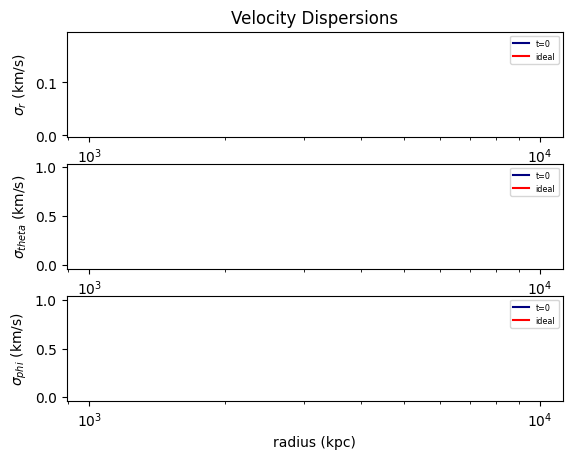

In [64]:
 #Plots the velocity dispersion
if r_center0 is not None:
    figure, axis = plt.subplots(3, 1)
    plt.subplots_adjust(hspace = .25)

    #First plot - Radial Dispersions
    axis[0].plot(r_center0,vdr0, label = 't=0', color = 'navy')
    if orbited == True:
        axis[0].plot(r_center,vdr, label = 't=' + time, color = 'g')
    axis[0].plot(r_center0,vd_ideal, label = 'ideal', color = 'r')
    axis[0].set_ylabel('$\sigma_r$ (km/s)')
    axis[0].set_title('Velocity Dispersions')
    axis[0].set_xscale('log')
    axis[0].legend(fontsize = 'xx-small')

    #Second Plot - Theta Dispersions
    axis[1].plot(r_center0,vdtheta0, label = 't=0', color = 'navy')
    if orbited == True:
        axis[1].plot(r_center,vdtheta, label = 't=' + time, color = 'g')
    axis[1].plot(r_center0,vd_ideal, label = 'ideal', color = 'r')
    axis[1].set_ylabel('$\sigma_{theta}$ (km/s)')
    axis[1].set_xscale('log')
    axis[1].legend(fontsize= 'xx-small')

    #Third Plot - Phi Dispersions
    axis[2].plot(r_center0,vdphi0, label = 't=0', color = 'navy')
    if orbited == True:
        axis[2].plot(r_center,vdphi, label = 't=' + time, color = 'g')
    axis[2].plot(r_center0,vd_ideal, label = 'ideal', color = 'r')
    axis[2].set_xlabel('radius (kpc)')
    axis[2].set_ylabel('$\sigma_{phi}$ (km/s)')
    axis[2].set_xscale('log')
    axis[2].legend(fontsize= 'xx-small')


### Energy over Time - Galactic Units

In [65]:
runcell = False 
#Generates data for the EOT plots
if runcell == True:
    Kinetic = []
    Potential = []
    Etot = []
    for i in tqdm(range(len(orbit.x))):
        r = np.sqrt(orbit[i].x**2+orbit[i].y**2+orbit[i].z**2)
        r = r/u.kpc
        v = np.sqrt(orbit[i].v_x**2+orbit[i].v_y**2+orbit[i].v_z**2)
        v = v.to(u.km/u.s)/(u.km/u.s)
        Kinetic += [sum(KE(m,v))]
        Potential += [sum(PE(G,M,b,r))]
        Etot += [Kinetic[-1]+Potential[-1]]


In [66]:
if Kinetic is not None:
    #Plots the EOT graph for KE_tot, PE_tot, and E_tot
    x = np.arange(0,len(orbit.x),1)
    Eavg = abs(sum(Etot)/len(Etot))
    plt.plot(x,Kinetic/Eavg, label = 'KE')
    plt.plot(x,Potential/Eavg, label = 'PE')
    plt.plot(x,Etot/Eavg, label = 'Etot')
    plt.xlabel('time (Myr)')
    plt.ylabel('Energy $(E)$')
    plt.title('Energy over Time')
    plt.legend()


NameError: name 'Kinetic' is not defined

### Plots Orbits in the given potential

In [ ]:
n_i = 42 #Selects which particle trajectory will be modeled
x0,v0 = q[n_i],p[n_i]

if unit_type == 'galactic':
    if potential_type == 'plummer':
        potential = gp.PlummerPotential(m = M*u.solMass,b= 1.5*u.kpc, units = galactic)
    w0 = gd.PhaseSpacePosition(pos=x0*u.kpc,vel=v0*u.km/u.s)
    orbit = potential.integrate_orbit(w0, dt=1*u.Myr, t1=0, t2=100*u.Gyr)
    ax = plt.axes(projection='3d')
    ax.plot3D(orbit.x, orbit.y, orbit.z)

if unit_type == 'dimensionless':
    if potential_type == 'plummer':
        potential = gp.PlummerPotential(m = 1,b=b, units = dimensionless)
    w0 = gd.PhaseSpacePosition(pos=x0,vel=v0)
    orbit = potential.integrate_orbit(w0, dt=.01, t1=0, t2=100)
    ax = plt.axes(projection='3d')
    ax.plot3D(orbit.x, orbit.y, orbit.z)

### Scratch Work